In [447]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
import pickle
from sklearn.metrics import f1_score, precision_score, recall_score
import plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode
import plotly.graph_objs as go
import cufflinks as cf
import glob
cf.go_offline()
init_notebook_mode(connected=True)


In [612]:
output_path = '../output/MSL'

In [613]:
pot = pd.read_pickle(f'{output_path}/anomaly_preds.pkl')
pot['anomaly'] = pot['anomaly'].astype(int)
pot.head()

,a_score,pot_threshold,pred_anomaly,anomaly
0,0.081065,1.359734,0,0
1,0.059598,1.359734,0,0
2,0.081242,1.359734,0,0
3,0.032153,1.359734,0,0
4,0.046852,1.359734,0,0


In [614]:
output = pd.read_pickle(f'{output_path}/preds.pkl')
test_anomaly_scores = np.load(f"{output_path}/test_scores.npy")

output['Tot_A_Score'] = test_anomaly_scores
output['Pred_Anomaly'] = pot['pred_anomaly']
output['True_Anomaly'] = pot['anomaly']
output['threshold'] = pot['pot_threshold']


output.head()
#plt.tight_layout()
#colors = ['gray', 'gray', 'gray', 'r']*(output.shape[1] // 4)
#output.iloc[:, :].plot(subplots=True, style=colors, ylim=(0, 5))
#plt.show();

,Pred_0,Recon_0,True_0,A_Score_0,Tot_A_Score,Pred_Anomaly,True_Anomaly,threshold
0,-1.012447,-0.931382,-0.996880,0.081065,0.081065,0,0,1.359734
1,-0.996778,-0.937384,-0.996880,0.059598,0.059598,0,0,1.359734
2,-1.004802,-0.923560,-0.998440,0.081242,0.081242,0,0,1.359734
3,-0.982557,-0.950404,-0.978159,0.032153,0.032153,0,0,1.359734
4,-0.985020,-0.938168,-0.976599,0.046852,0.046852,0,0,1.359734


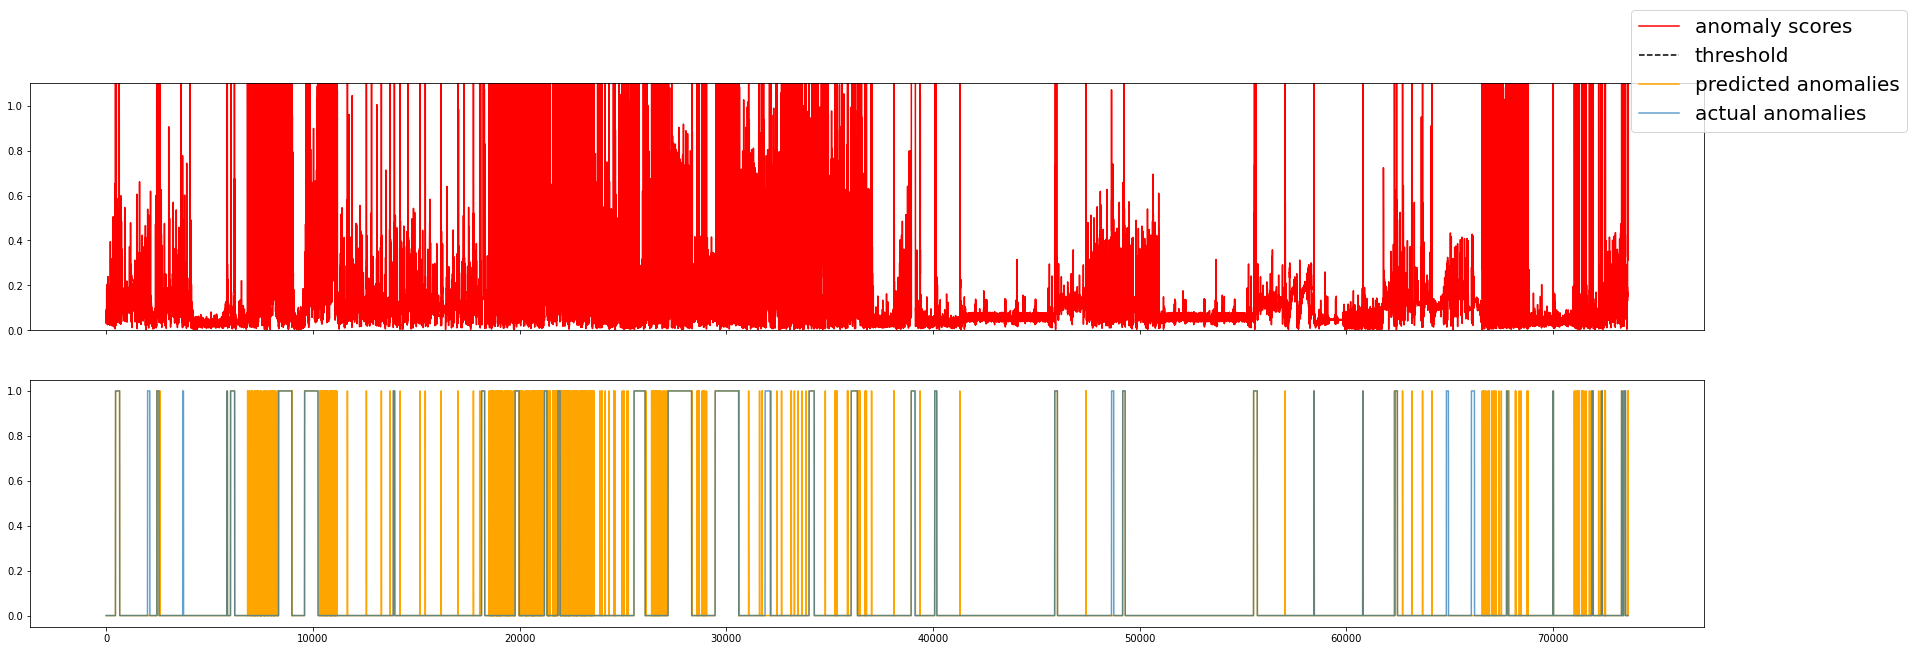

In [615]:
fig, axs = plt.subplots(2, figsize=(30, 10), sharex=True, )
axs[0].plot(pot['a_score'], c='r', label='anomaly scores')
axs[0].plot(pot['pot_threshold'], linestyle='dashed', c='black', label='threshold')
axs[1].plot(pot['pred_anomaly'], label='predicted anomalies', c='orange')
axs[1].plot(pot['anomaly'], label='actual anomalies', alpha=0.7)
axs[0].set_ylim([0, 1.1])

fig.legend(prop={'size': 20})
plt.show()

In [616]:
print('precision: ', precision_score(pot['anomaly'], pot['pred_anomaly']))
print('recall:    ', recall_score(pot['anomaly'], pot['pred_anomaly']))
print('f1 score:  ', f1_score(pot['anomaly'], pot['pred_anomaly']))

precision:  0.9095509992213859
recall:     0.9025238217872779
f1 score:   0.9060237849017581


In [617]:
# Meta data 
md = pd.read_csv('../datasets/data/labeled_anomalies.csv')
md.head()

,chan_id,spacecraft,anomaly_sequences,class,num_values
0,P-1,SMAP,"[[2149, 2349], [4536, 4844], [3539, 3779]]","[contextual, contextual, contextual]",8505
1,S-1,SMAP,"[[5300, 5747]]",[point],7331
2,E-1,SMAP,"[[5000, 5030], [5610, 6086]]","[contextual, contextual]",8516
3,E-2,SMAP,"[[5598, 6995]]",[point],8532
4,E-3,SMAP,"[[5094, 8306]]",[point],8307


In [618]:
def create_shapes(ranges, sequence_type, _min, _max, plot_values):
    """
    Create shapes for regions to highlight in plotly vizzes (true and
    predicted anomaly sequences). Will plot labeled anomalous ranges if
    available.

    Args:
        ranges (list of tuples): tuple of start and end indices for anomaly
            sequences for a channel
        sequence_type (str): "predict" if predicted values else
            "true" if actual values. Determines colors.
        _min (float): min y value of series
        _max (float): max y value of series
        plot_values (dict): dictionary of different series to be plotted
            (predicted, actual, errors, training data)

    Returns:
        (dict) shape specifications for plotly
    """

    if not _max:
        _max = max(plot_values['errors'])

    color = 'red' if sequence_type == 'true' else 'blue'
    shapes = []

    for r in ranges:
        shape = {
            'type': 'rect',
            'x0': r[0]-10, #self.config.l_s,
            'y0': _min,
            'x1': r[1]+10, #self.config.l_s,
            'y1': _max,
            'fillcolor': color,
            'opacity': 0.2,
            'line': {
                'width': 0,
            }
        }
        shapes.append(shape)

    return shapes

In [619]:
def get_anomaly_sequences(values):
    splits = np.where(values[1:] != values[:-1])[0] + 1

    a_seqs = []
    for i in range(0, len(splits)-1, 2):
        a_seqs.append([splits[i], splits[i+1]-1])

    if len(splits) % 2 == 1:
        a_seqs.append([splits[-1], len(values)-1])

    return a_seqs

In [620]:
def plot_channel(output, channel, start=None, end=None, plot_errors=True):
    """ Plot forecasting, reconstruction, true value of a specific channel (feature),
        along with the anomaly score for that channel
    """

    output_copy = output.copy()
    
    if start is not None:
        output_copy = output_copy.iloc[start:, :]
    if end is not None:
        start = 0 if start is None else start
        output_copy = output_copy.iloc[:end-start, :]
    
    output_copy = output_copy.reset_index()
    i = channel
    plot_values = {
    'y_forecast': output_copy[f'Pred_{i}'].values,
    'y_recon': output_copy[f'Recon_{i}'].values,
    'y_true': output_copy[f'True_{i}'].values,
    #'errors': output_copy[f'A_Score_{i}'].values,
    'errors': output_copy[f'Tot_A_Score'].values,
    'threshold': output_copy['threshold'].values,
    }

    anomaly_sequences = {
        'pred': get_anomaly_sequences(output_copy['Pred_Anomaly'].values),
        'true': get_anomaly_sequences(output_copy['True_Anomaly'].values)
    }
    
    y_min = plot_values['y_true'].min()
    y_max = plot_values['y_true'].max()
    e_max = plot_values['errors'].max()
    
    y_min -= 0.3*y_max
    y_max += 0.5*y_max
    e_max += 0.5*e_max
    
    y_shapes = create_shapes(anomaly_sequences['true'], 'true', y_min, y_max, plot_values)
    e_shapes = create_shapes(anomaly_sequences['true'], 'true', 0, e_max, plot_values)

    y_shapes += create_shapes(anomaly_sequences['pred'], 'predicted', y_min, y_max, plot_values)
    e_shapes += create_shapes(anomaly_sequences['pred'], 'predicted', 0, e_max, plot_values)

    y_df = pd.DataFrame({
        'y_forecast': plot_values['y_forecast'].reshape(-1,),
        'y_recon': plot_values['y_recon'].reshape(-1,),
        'y_true': plot_values['y_true'].reshape(-1,)
    })

    e_df = pd.DataFrame({
        'e_s': plot_values['errors'].reshape(-1,),
        'threshold': plot_values['threshold'].reshape(-1,)
    })

    y_layout = {
        'title': 'y / y_hat comparison',
        'shapes': y_shapes,
        'yaxis': dict(
            range=[y_min, y_max]
        ),
        'showlegend': True
    }

    e_layout = {
        'title': "Errors",
        'shapes': e_shapes,
        'yaxis': dict(
            range=[0, e_max]
        )
        
    }
    
    lines = [
        go.Scatter(x=y_df['y_true'].index, y=y_df['y_true'], line_color='rgb(0, 204, 150, 0.5)', name='y_true'),
        go.Scatter(x=y_df['y_forecast'].index, y=y_df['y_forecast'], line_color='rgb(255, 127, 14, 1)', name='y_forecast'),
        go.Scatter(x=y_df['y_recon'].index, y=y_df['y_recon'], line_color='rgb(31, 119, 180, 1)', name='y_recon'), 
    ]
        
    fig = go.Figure(
        data=lines,
        layout=y_layout#go.Layout(showlegend=True)
    )
    py.offline.iplot(fig)

    #y_df.iplot(kind='scatter', layout=y_layout, opacity=0.01)

    if plot_errors:
        e_df.iplot(kind='scatter', layout=e_layout, colors=['red', 'black'], dash=[None, 'dash'])
        #e_df.iplot(kind='scatter', layout=e_layout, colors=['red'])

In [630]:
plot_channel(output, channel=0, start=45500, end=50000)

In [521]:
output.head()

,Pred_0,Recon_0,True_0,A_Score_0,Tot_A_Score,Pred_Anomaly,True_Anomaly,threshold
0,-1.012447,-0.931382,-0.996880,0.081065,0.081065,0,0,1.359734
1,-0.996778,-0.937384,-0.996880,0.059598,0.059598,0,0,1.359734
2,-1.004802,-0.923560,-0.998440,0.081242,0.081242,0,0,1.359734
3,-0.982557,-0.950404,-0.978159,0.032153,0.032153,0,0,1.359734
4,-0.985020,-0.938168,-0.976599,0.046852,0.046852,0,0,1.359734
